
WALK-FORWARD VALIDATION PERIOD (FOLD 1-7)


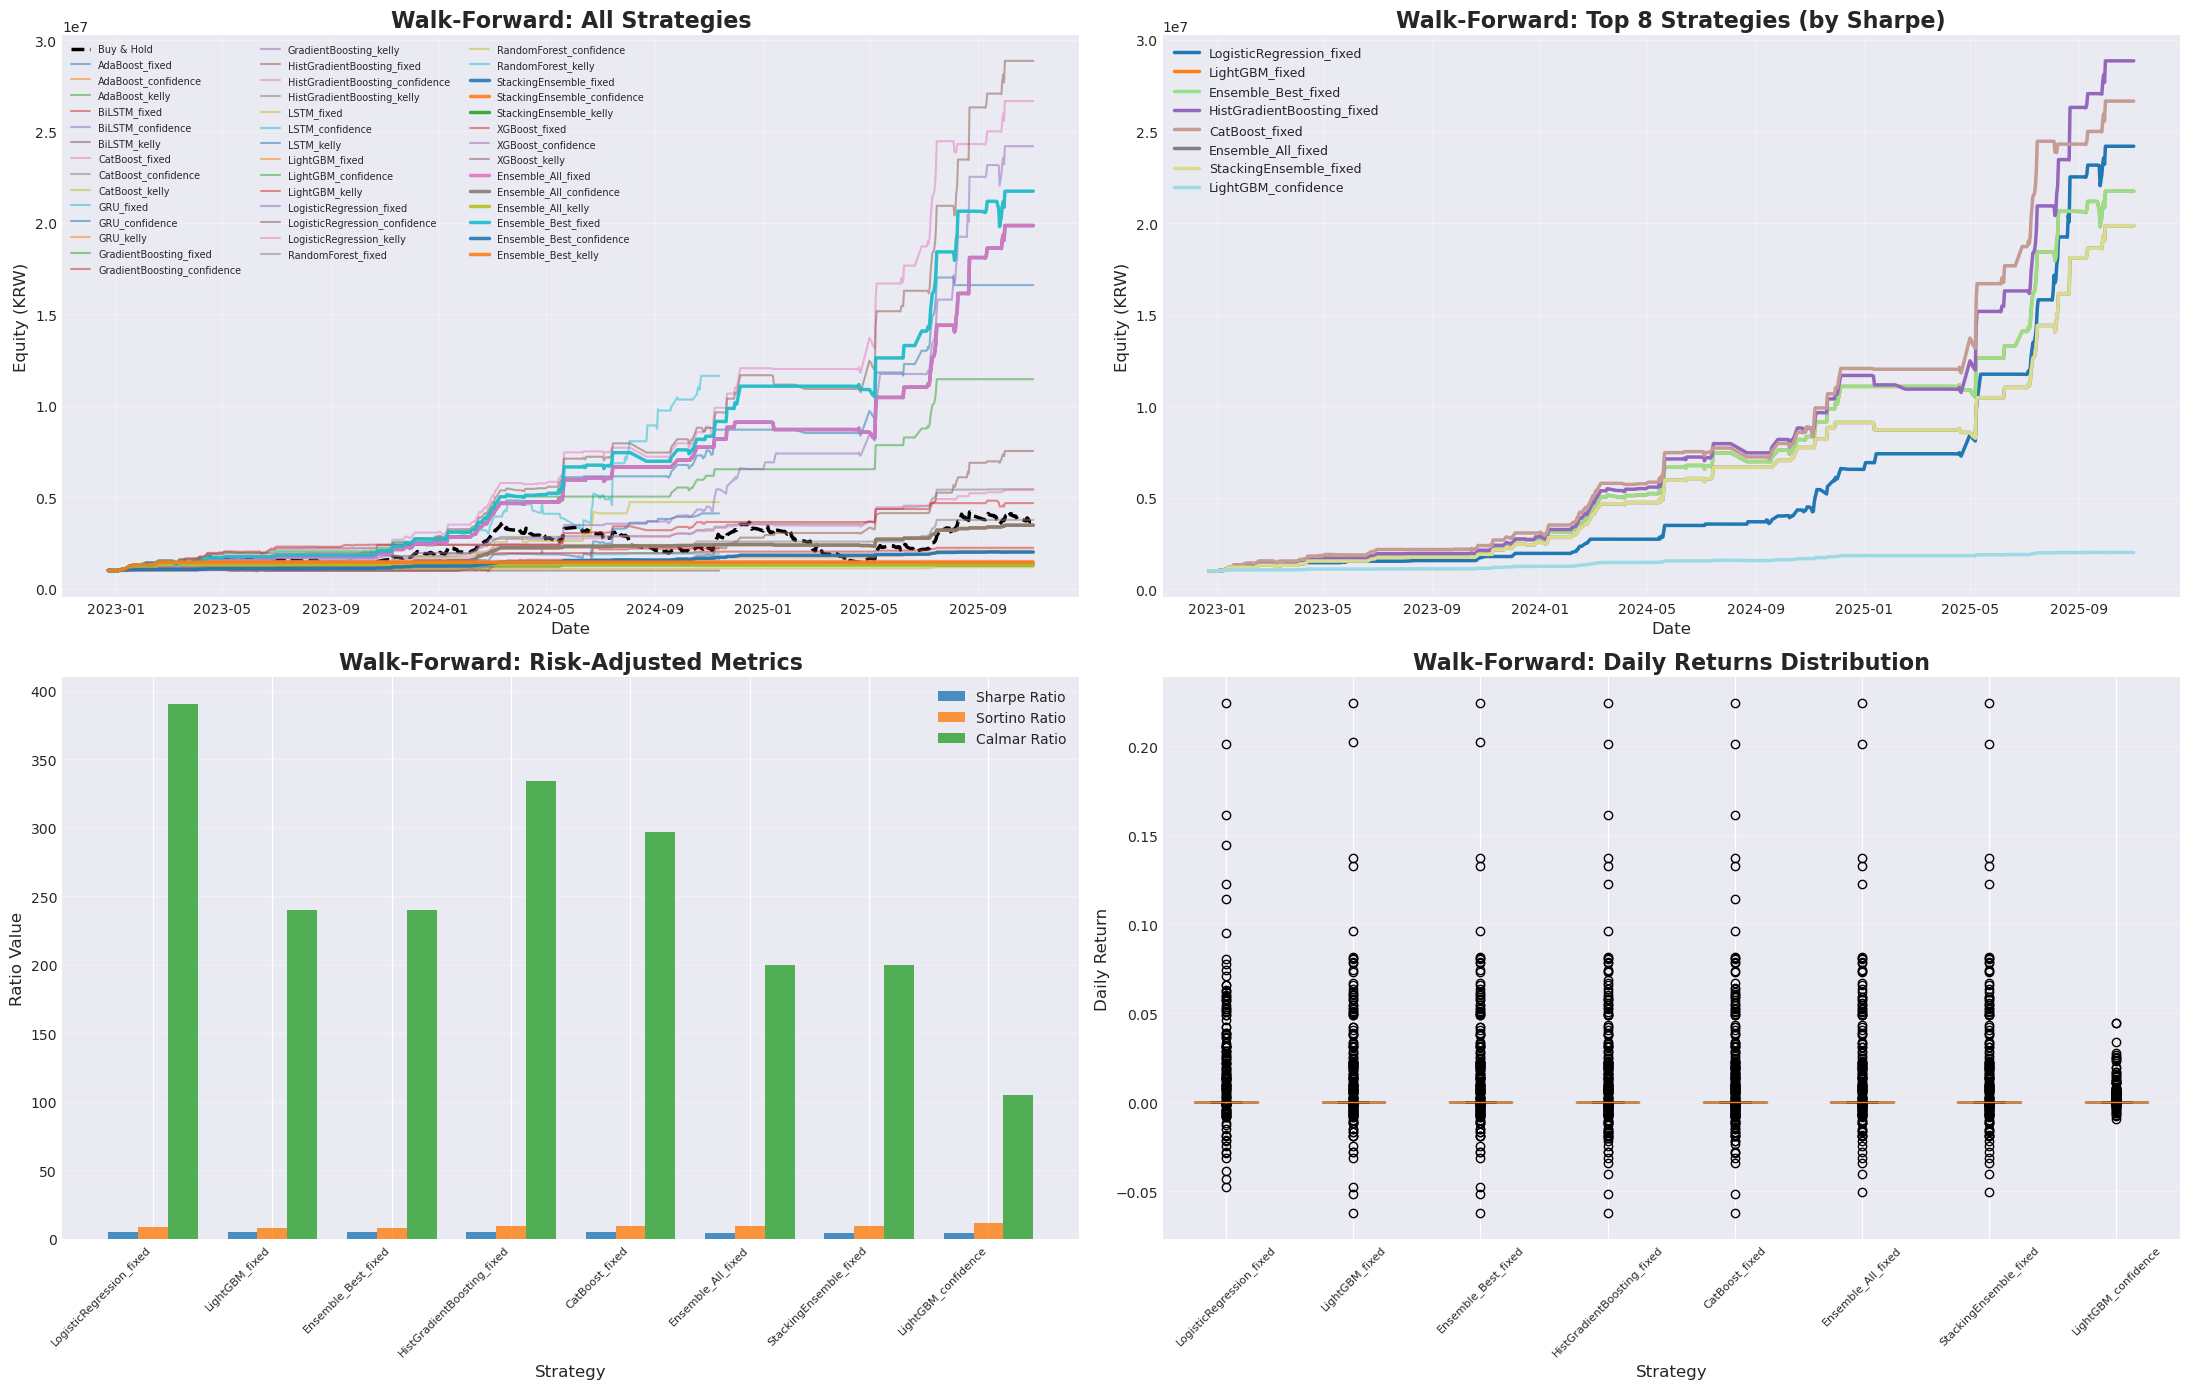

Walk-Forward: PERFORMANCE SUMMARY
                                Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Win Rate Profit Factor Avg Trade
LogisticRegression_fixed             2319.56%   -5.94%        4.716         8.464      390.220   61.40%         4.474   0.4994%
LightGBM_fixed                       2073.70%   -8.65%        4.674         8.130      239.672   55.50%         4.697   0.4826%
Ensemble_Best_fixed                  2073.70%   -8.65%        4.674         8.130      239.672   55.50%         4.697   0.4826%
HistGradientBoosting_fixed           2786.07%   -8.34%        4.672         9.351      334.175   51.87%         4.597   0.5270%
CatBoost_fixed                       2566.17%   -8.65%        4.654         9.312      296.590   53.56%         4.406   0.5146%
Ensemble_All_fixed                   1885.55%   -9.42%        4.536         9.281      200.142   53.77%         5.187   0.4684%
StackingEnsemble_fixed               1885.55%   -9.42%        4.536   

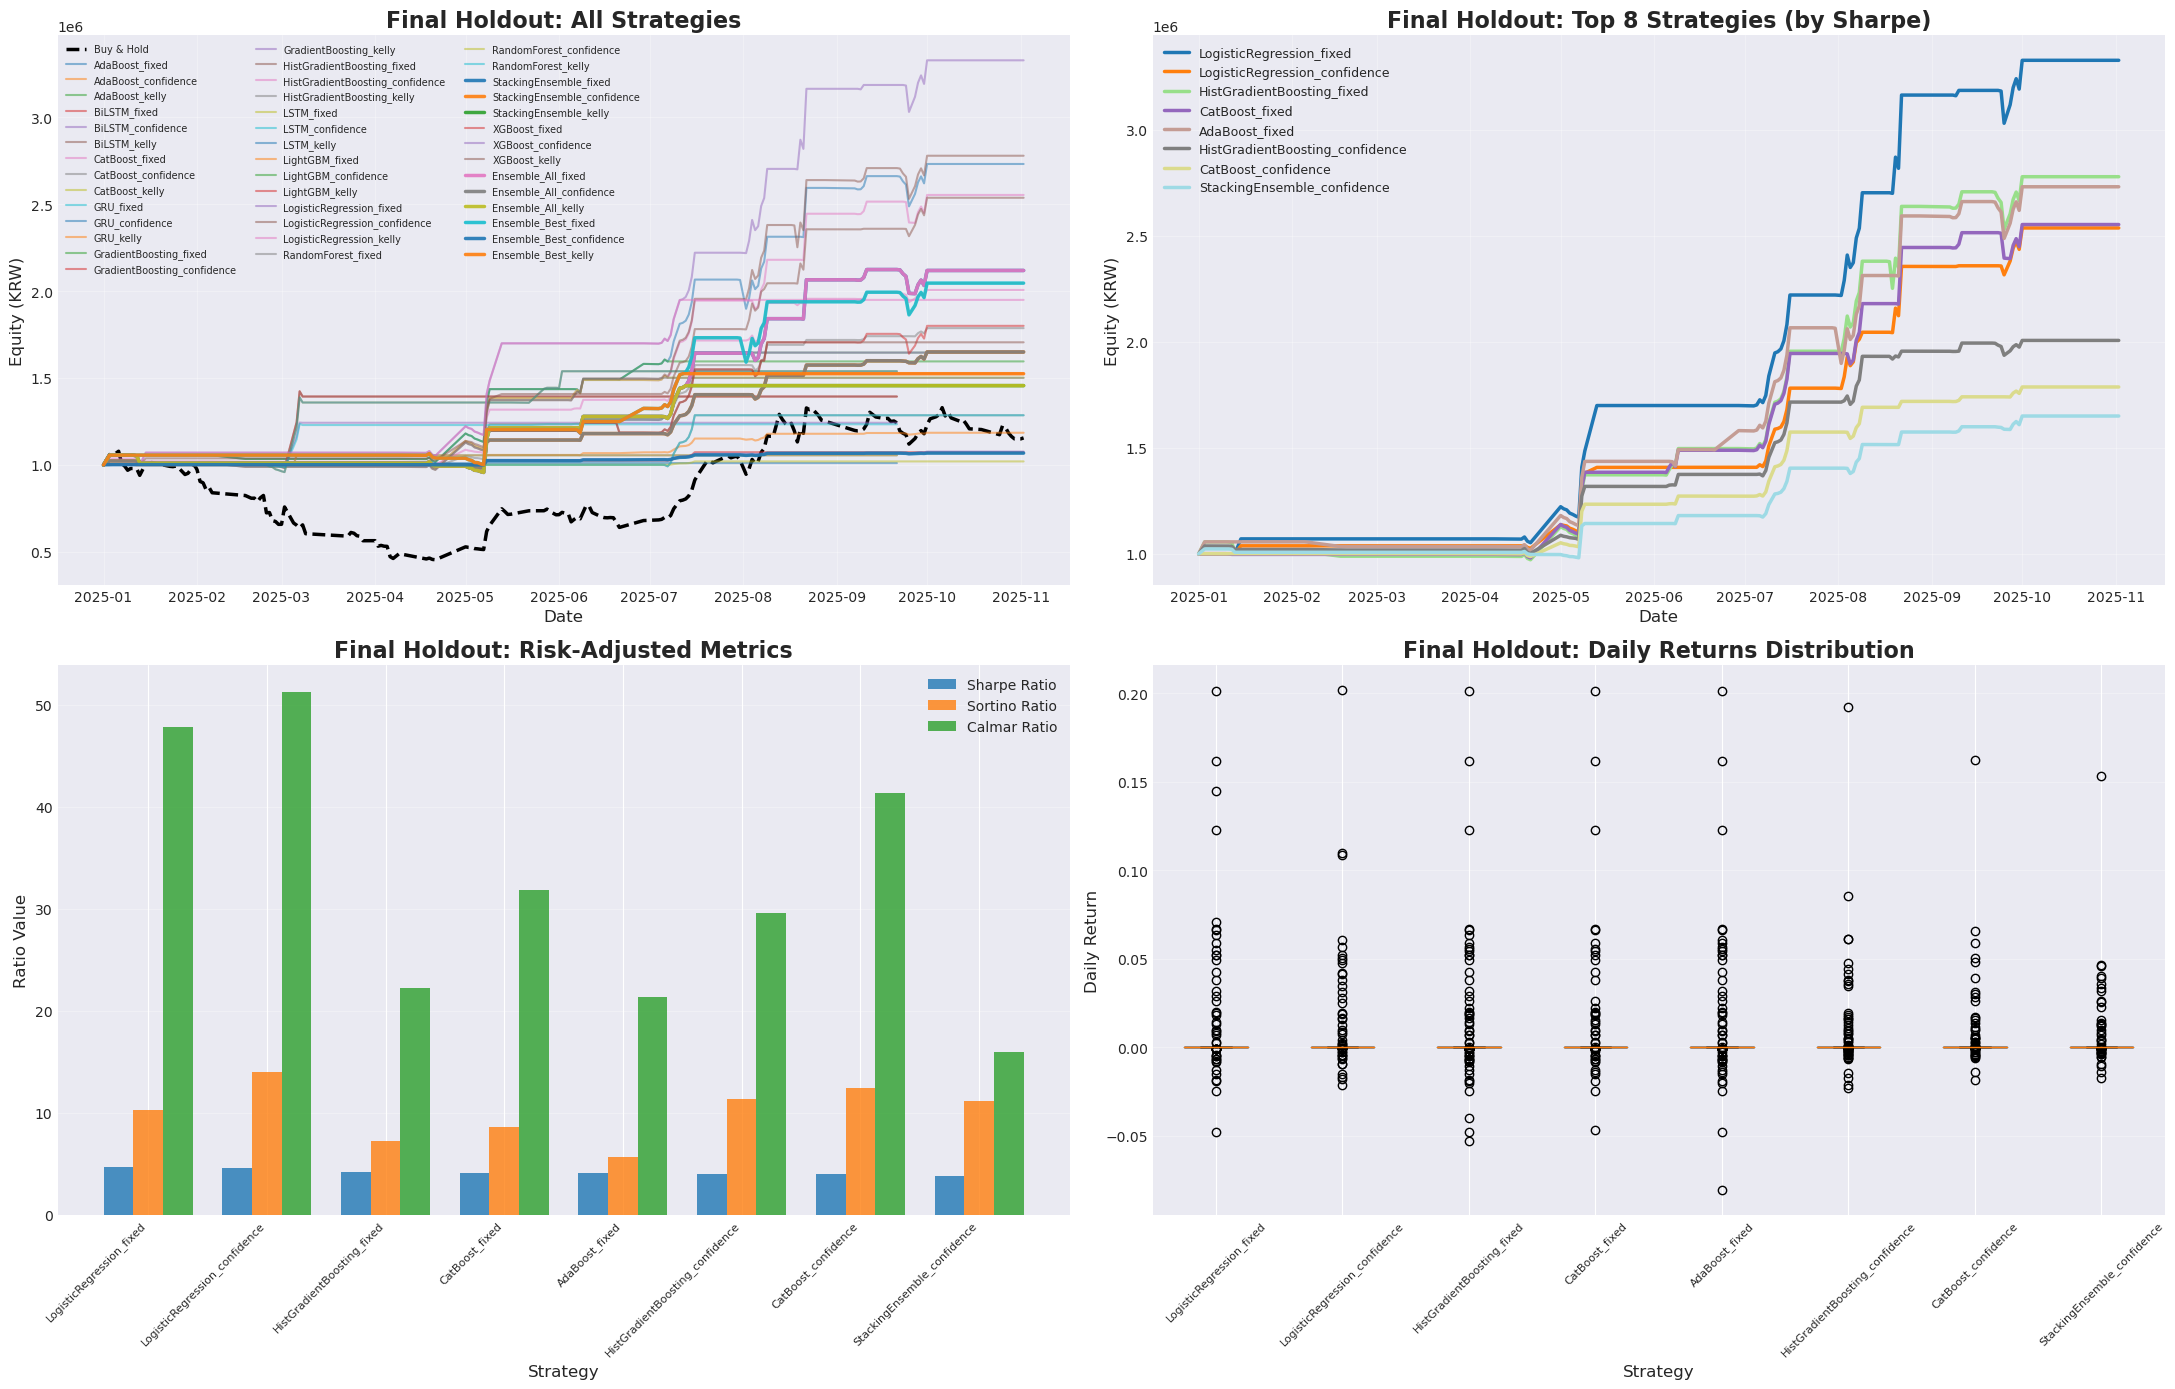

Final Holdout: PERFORMANCE SUMMARY
                                Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Win Rate Profit Factor Avg Trade
LogisticRegression_fixed              232.75%   -4.87%        4.741        10.293       47.786   59.18%         5.070   0.6294%
LogisticRegression_confidence         153.66%   -3.00%        4.591        14.003       51.288   59.18%         5.817   0.4873%
HistGradientBoosting_fixed            178.12%   -8.00%        4.179         7.204       22.277   51.56%         3.832   0.5350%
CatBoost_fixed                        155.28%   -4.87%        4.131         8.604       31.880   54.90%         4.916   0.4907%
AdaBoost_fixed                        173.37%   -8.14%        4.080         5.706       21.310   52.54%         3.813   0.5260%
HistGradientBoosting_confidence       100.74%   -3.40%        4.021        11.319       29.616   51.56%         5.733   0.3645%
CatBoost_confidence                    78.65%   -1.90%        4.014  

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats
from itertools import combinations

def calculate_performance_metrics(equity_curve, daily_returns):
    total_returns = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
    
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    mdd = drawdown.min()
    
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(365) if daily_returns.std() != 0 else 0
    sortino_ratio = (daily_returns.mean() / daily_returns[daily_returns < 0].std()) * np.sqrt(365) if len(daily_returns[daily_returns < 0]) > 0 and daily_returns[daily_returns < 0].std() != 0 else 0
    calmar_ratio = (total_returns / abs(mdd)) if mdd != 0 else 0
    
    win_rate = len(daily_returns[daily_returns > 0]) / len(daily_returns[daily_returns != 0]) if len(daily_returns[daily_returns != 0]) > 0 else 0
    avg_win = daily_returns[daily_returns > 0].mean() if len(daily_returns[daily_returns > 0]) > 0 else 0
    avg_loss = daily_returns[daily_returns < 0].mean() if len(daily_returns[daily_returns < 0]) > 0 else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    
    return {
        "Total Returns": total_returns,
        "MDD": mdd,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Calmar Ratio": calmar_ratio,
        "Win Rate": win_rate,
        "Profit Factor": profit_factor,
        "Avg Trade": daily_returns.mean()
    }

def realistic_trading_simulation(predictions_df, price_df, lookahead, fee_rate=0.0005, slippage_rate=0.0005):
    predictions_df['date'] = pd.to_datetime(predictions_df['date'])
    sim_df = pd.merge(predictions_df, price_df, on='date', how='inner').sort_values(by='date').reset_index(drop=True)
    
    daily_log_returns = pd.Series(0.0, index=sim_df.index)
    position = None

    for i in range(len(sim_df)):
        if position:
            unrealized_return = np.log(sim_df.loc[i, 'ETH_Close'] / sim_df.loc[i-1, 'ETH_Close'])
            daily_log_returns.iloc[i] = unrealized_return

        if position:
            exit_price = None
            days_in_trade = i - position['entry_day_index']
            
            if sim_df.loc[i, 'ETH_High'] >= position['take_profit']:
                exit_price = position['take_profit']
            elif sim_df.loc[i, 'ETH_Low'] <= position['stop_loss']:
                exit_price = position['stop_loss']
            
            if not exit_price and days_in_trade >= lookahead:
                if i + 1 < len(sim_df):
                    exit_price = sim_df.loc[i + 1, 'ETH_Open']
                else:
                    exit_price = sim_df.loc[i, 'ETH_Close']

            if exit_price:
                trade_cost = fee_rate + slippage_rate
                daily_log_returns.iloc[i] -= trade_cost
                position = None
        
        if not position and sim_df.loc[i, 'signal'] == 1 and (i + 1 < len(sim_df)):
            trade_cost = fee_rate + slippage_rate
            daily_log_returns.iloc[i] -= trade_cost
            position = {
                'entry_price': sim_df.loc[i + 1, 'ETH_Open'],
                'take_profit': sim_df.loc[i, 'take_profit_price'],
                'stop_loss': sim_df.loc[i, 'stop_loss_price'],
                'entry_day_index': i + 1,
            }
            
    return daily_log_returns

def calculate_kelly_criterion(win_rate, avg_win, avg_loss):
    if avg_loss == 0 or win_rate == 0:
        return 0
    win_loss_ratio = abs(avg_win / avg_loss)
    kelly = (win_rate * win_loss_ratio - (1 - win_rate)) / win_loss_ratio
    return max(0, min(kelly, 0.25))

def dynamic_position_sizing(predictions_df, price_df, lookahead, sizing_method='fixed', fee_rate=0.0005, slippage_rate=0.0005):
    predictions_df['date'] = pd.to_datetime(predictions_df['date'])
    sim_df = pd.merge(predictions_df, price_df, on='date', how='inner').sort_values(by='date').reset_index(drop=True)
    
    daily_log_returns = pd.Series(0.0, index=sim_df.index)
    position = None
    trade_history = []
    
    for i in range(len(sim_df)):
        if position:
            unrealized_return = np.log(sim_df.loc[i, 'ETH_Close'] / sim_df.loc[i-1, 'ETH_Close'])
            daily_log_returns.iloc[i] = unrealized_return * position['size']

        if position:
            exit_price = None
            days_in_trade = i - position['entry_day_index']
            
            if sim_df.loc[i, 'ETH_High'] >= position['take_profit']:
                exit_price = position['take_profit']
            elif sim_df.loc[i, 'ETH_Low'] <= position['stop_loss']:
                exit_price = position['stop_loss']
            
            if not exit_price and days_in_trade >= lookahead:
                if i + 1 < len(sim_df):
                    exit_price = sim_df.loc[i + 1, 'ETH_Open']
                else:
                    exit_price = sim_df.loc[i, 'ETH_Close']

            if exit_price:
                trade_cost = fee_rate + slippage_rate
                daily_log_returns.iloc[i] -= trade_cost * position['size']
                
                trade_return = np.log(exit_price / position['entry_price']) - trade_cost
                trade_history.append(trade_return * position['size'])
                
                position = None
        
        if not position and sim_df.loc[i, 'signal'] == 1 and (i + 1 < len(sim_df)):
            trade_cost = fee_rate + slippage_rate
            
            if sizing_method == 'fixed':
                position_size = 1.0
            elif sizing_method == 'confidence':
                position_size = sim_df.loc[i, 'confidence']
            elif sizing_method == 'kelly' and len(trade_history) >= 20:
                recent_trades = pd.Series(trade_history[-20:])
                win_rate = len(recent_trades[recent_trades > 0]) / len(recent_trades)
                avg_win = recent_trades[recent_trades > 0].mean() if len(recent_trades[recent_trades > 0]) > 0 else 0
                avg_loss = recent_trades[recent_trades < 0].mean() if len(recent_trades[recent_trades < 0]) > 0 else 0
                position_size = calculate_kelly_criterion(win_rate, avg_win, avg_loss)
            else:
                position_size = 1.0
            
            daily_log_returns.iloc[i] -= trade_cost * position_size
            position = {
                'entry_price': sim_df.loc[i + 1, 'ETH_Open'],
                'take_profit': sim_df.loc[i, 'take_profit_price'],
                'stop_loss': sim_df.loc[i, 'stop_loss_price'],
                'entry_day_index': i + 1,
                'size': position_size
            }
            
    return daily_log_returns

def run_separated_backtest(pred_base_path, master_raw_file_path, confidence_threshold=0.5, lookahead=5, initial_capital=1_000_000):
    price_df = pd.read_csv(master_raw_file_path, usecols=['date', 'ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Close'])
    price_df['date'] = pd.to_datetime(price_df['date'])

    all_pred_files = glob.glob(os.path.join(pred_base_path, "fold_*", "*_predictions.csv"))
    
    wf_files = [f for f in all_pred_files if 'final_holdout' not in f]
    ho_files = [f for f in all_pred_files if 'final_holdout' in f]
    
    wf_model_files = {}
    for f in wf_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        if model_name not in wf_model_files:
            wf_model_files[model_name] = []
        wf_model_files[model_name].append(f)
    
    ho_model_files = {}
    for f in ho_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        if model_name not in ho_model_files:
            ho_model_files[model_name] = []
        ho_model_files[model_name].append(f)

    def backtest_period(model_files_dict, period_name):
        all_dates_df = pd.concat([pd.read_csv(f)[['date']] for files in model_files_dict.values() for f in files]).drop_duplicates().sort_values('date')
        all_test_dates = pd.to_datetime(all_dates_df['date'])
        
        performance_summary = {}
        all_equity_curves = {}
        
        bnh_df = price_df[price_df['date'].isin(all_test_dates)].copy().reset_index(drop=True)
        bnh_df['bnh_return'] = np.log(bnh_df['ETH_Close'] / bnh_df['ETH_Close'].shift(1)).fillna(0)
        bnh_equity = initial_capital * np.exp(bnh_df['bnh_return'].cumsum())
        bnh_metrics = calculate_performance_metrics(bnh_equity, bnh_df['bnh_return'])
        performance_summary['Buy_Hold'] = bnh_metrics
        all_equity_curves['Buy_Hold'] = bnh_equity

        for model_name, files in sorted(model_files_dict.items()):
            preds_df = pd.concat([pd.read_csv(f) for f in files]).drop_duplicates(subset=['date']).sort_values('date').reset_index(drop=True)
            preds_df['signal'] = np.where((preds_df['pred_direction'] == 1) & (preds_df['confidence'] >= confidence_threshold), 1, 0)
            
            for sizing_method in ['fixed', 'confidence', 'kelly']:
                strategy_log_returns = dynamic_position_sizing(preds_df, price_df, lookahead, sizing_method=sizing_method)
                strategy_equity = initial_capital * np.exp(strategy_log_returns.cumsum())
                
                if len(strategy_equity) > 0:
                    strategy_key = f"{model_name}_{sizing_method}"
                    performance_summary[strategy_key] = calculate_performance_metrics(strategy_equity, strategy_log_returns)
                    all_equity_curves[strategy_key] = strategy_equity

        voting_threshold = 0.3
        ensemble_dates = all_dates_df.copy()
        ensemble_dates['date'] = pd.to_datetime(ensemble_dates['date'])
        ensemble_dates['vote'] = 0
        
        for model_name, files in model_files_dict.items():
            model_df = pd.concat([pd.read_csv(f) for f in files]).drop_duplicates(subset=['date']).sort_values('date')
            model_df['date'] = pd.to_datetime(model_df['date'])
            model_df['model_signal'] = np.where((model_df['pred_direction'] == 1) & (model_df['confidence'] >= confidence_threshold), 1, 0)
            
            ensemble_dates = pd.merge(ensemble_dates, model_df[['date', 'model_signal', 'take_profit_price', 'stop_loss_price', 'confidence']], 
                                      on='date', how='left', suffixes=('', f'_{model_name}'))
            ensemble_dates['vote'] += ensemble_dates['model_signal'].fillna(0)
            
            if 'take_profit_price' not in ensemble_dates.columns:
                ensemble_dates['take_profit_price'] = model_df['take_profit_price']
                ensemble_dates['stop_loss_price'] = model_df['stop_loss_price']
            
            if 'confidence' not in ensemble_dates.columns or pd.isna(ensemble_dates['confidence']).all():
                ensemble_dates['confidence'] = model_df['confidence']
        
        ensemble_dates['signal'] = np.where(ensemble_dates['vote'] >= len(model_files_dict) * voting_threshold, 1, 0)
        
        for sizing_method in ['fixed', 'confidence', 'kelly']:
            ensemble_log_returns = dynamic_position_sizing(ensemble_dates, price_df, lookahead, sizing_method=sizing_method)
            ensemble_equity = initial_capital * np.exp(ensemble_log_returns.cumsum())
            
            if len(ensemble_equity) > 0:
                strategy_key = f"Ensemble_All_{sizing_method}"
                performance_summary[strategy_key] = calculate_performance_metrics(ensemble_equity, ensemble_log_returns)
                all_equity_curves[strategy_key] = ensemble_equity

        best_models = ['LightGBM', 'XGBoost', 'CatBoost']
        available_best = [m for m in best_models if m in model_files_dict]
        
        if len(available_best) >= 2:
            best_ensemble = all_dates_df.copy()
            best_ensemble['date'] = pd.to_datetime(best_ensemble['date'])
            best_ensemble['vote'] = 0
            
            for model_name in available_best:
                files = model_files_dict[model_name]
                model_df = pd.concat([pd.read_csv(f) for f in files]).drop_duplicates(subset=['date']).sort_values('date')
                model_df['date'] = pd.to_datetime(model_df['date'])
                model_df['model_signal'] = np.where((model_df['pred_direction'] == 1) & (model_df['confidence'] >= confidence_threshold), 1, 0)
                
                best_ensemble = pd.merge(best_ensemble, model_df[['date', 'model_signal', 'take_profit_price', 'stop_loss_price', 'confidence']], 
                                          on='date', how='left', suffixes=('', f'_{model_name}'))
                best_ensemble['vote'] += best_ensemble['model_signal'].fillna(0)
                
                if 'take_profit_price' not in best_ensemble.columns:
                    best_ensemble['take_profit_price'] = model_df['take_profit_price']
                    best_ensemble['stop_loss_price'] = model_df['stop_loss_price']
                
                if 'confidence' not in best_ensemble.columns or pd.isna(best_ensemble['confidence']).all():
                    best_ensemble['confidence'] = model_df['confidence']
            
            best_ensemble['signal'] = np.where(best_ensemble['vote'] >= len(available_best) * 0.5, 1, 0)
            
            for sizing_method in ['fixed', 'confidence', 'kelly']:
                best_log_returns = dynamic_position_sizing(best_ensemble, price_df, lookahead, sizing_method=sizing_method)
                best_equity = initial_capital * np.exp(best_log_returns.cumsum())
                
                if len(best_equity) > 0:
                    strategy_key = f"Ensemble_Best_{sizing_method}"
                    performance_summary[strategy_key] = calculate_performance_metrics(best_equity, best_log_returns)
                    all_equity_curves[strategy_key] = best_equity

        fig, axes = plt.subplots(2, 2, figsize=(22, 14))
        
        axes[0, 0].plot(bnh_df['date'], bnh_equity, label='Buy & Hold', color='black', linestyle='--', linewidth=2.5)
        for strategy_name, equity in all_equity_curves.items():
            if strategy_name != 'Buy_Hold':
                alpha = 0.9 if 'Ensemble' in strategy_name else 0.5
                linewidth = 2.5 if 'Ensemble' in strategy_name else 1.5
                axes[0, 0].plot(bnh_df['date'][:len(equity)], equity, label=strategy_name, alpha=alpha, linewidth=linewidth)
        
        axes[0, 0].set_title(f'{period_name}: All Strategies', fontsize=16, fontweight='bold')
        axes[0, 0].set_xlabel('Date', fontsize=12)
        axes[0, 0].set_ylabel('Equity (KRW)', fontsize=12)
        axes[0, 0].legend(loc='upper left', fontsize=7, ncol=3)
        axes[0, 0].grid(True, alpha=0.3)

        summary_df = pd.DataFrame.from_dict(performance_summary, orient='index')
        summary_df = summary_df.sort_values('Sharpe Ratio', ascending=False)
        
        top_strategies = summary_df.head(8).index.tolist()
        colors = plt.cm.tab20(np.linspace(0, 1, len(top_strategies)))
        
        for idx, strategy in enumerate(top_strategies):
            if strategy in all_equity_curves:
                dates = bnh_df['date'][:len(all_equity_curves[strategy])]
                axes[0, 1].plot(dates, all_equity_curves[strategy], 
                              label=strategy, linewidth=2.5, color=colors[idx])
        
        axes[0, 1].set_title(f'{period_name}: Top 8 Strategies (by Sharpe)', fontsize=16, fontweight='bold')
        axes[0, 1].set_xlabel('Date', fontsize=12)
        axes[0, 1].set_ylabel('Equity (KRW)', fontsize=12)
        axes[0, 1].legend(loc='upper left', fontsize=9)
        axes[0, 1].grid(True, alpha=0.3)

        metrics = ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio']
        x = np.arange(len(top_strategies))
        width = 0.25
        
        for idx, metric in enumerate(metrics):
            values = [summary_df.loc[s, metric] if s in summary_df.index else 0 for s in top_strategies]
            axes[1, 0].bar(x + idx * width, values, width, label=metric, alpha=0.8)
        
        axes[1, 0].set_xlabel('Strategy', fontsize=12)
        axes[1, 0].set_ylabel('Ratio Value', fontsize=12)
        axes[1, 0].set_title(f'{period_name}: Risk-Adjusted Metrics', fontsize=16, fontweight='bold')
        axes[1, 0].set_xticks(x + width)
        axes[1, 0].set_xticklabels(top_strategies, rotation=45, ha='right', fontsize=8)
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3, axis='y')

        returns_data = []
        strategy_labels = []
        
        for strategy in top_strategies:
            if strategy in all_equity_curves:
                rets = pd.Series(all_equity_curves[strategy]).pct_change().dropna()
                returns_data.append(rets)
                strategy_labels.append(strategy)
        
        axes[1, 1].boxplot(returns_data, labels=strategy_labels)
        axes[1, 1].set_title(f'{period_name}: Daily Returns Distribution', fontsize=16, fontweight='bold')
        axes[1, 1].set_xlabel('Strategy', fontsize=12)
        axes[1, 1].set_ylabel('Daily Return', fontsize=12)
        axes[1, 1].tick_params(axis='x', rotation=45, labelsize=8)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()

        print("="*120)
        print(f"{period_name}: PERFORMANCE SUMMARY")
        print("="*120)
        
        display_df = summary_df.copy()
        display_df['Total Returns'] = display_df['Total Returns'].apply(lambda x: f"{x:.2%}")
        display_df['MDD'] = display_df['MDD'].apply(lambda x: f"{x:.2%}")
        display_df['Sharpe Ratio'] = display_df['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Sortino Ratio'] = display_df['Sortino Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Calmar Ratio'] = display_df['Calmar Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Win Rate'] = display_df['Win Rate'].apply(lambda x: f"{x:.2%}")
        display_df['Profit Factor'] = display_df['Profit Factor'].apply(lambda x: f"{x:.3f}")
        display_df['Avg Trade'] = display_df['Avg Trade'].apply(lambda x: f"{x:.4%}")
        
        print(display_df.to_string())
        print("="*120)

        print("\n" + "="*120)
        print(f"{period_name}: STATISTICAL TESTS")
        print("="*120)
        
        bnh_returns_array = bnh_df['bnh_return'].values
        
        for strategy in top_strategies:
            if strategy != 'Buy_Hold' and strategy in all_equity_curves:
                strategy_returns = pd.Series(all_equity_curves[strategy]).pct_change().dropna().values
                
                if len(strategy_returns) > 3:
                    t_stat, t_pval = stats.ttest_ind(strategy_returns, bnh_returns_array[:len(strategy_returns)])
                    
                    print(f"\n{strategy}:")
                    print(f"  T-test p-value: {t_pval:.4f} {'***' if t_pval < 0.01 else '**' if t_pval < 0.05 else '*' if t_pval < 0.1 else ''}")
        
        print("="*120)

        return summary_df

    print("\n" + "="*120)
    print("WALK-FORWARD VALIDATION PERIOD (FOLD 1-7)")
    print("="*120)
    wf_summary = backtest_period(wf_model_files, "Walk-Forward")

    print("\n\n" + "="*120)
    print("FINAL HOLDOUT PERIOD (FOLD 8)")
    print("="*120)
    ho_summary = backtest_period(ho_model_files, "Final Holdout")

pred_base_path = "../model_results/2025-11-09/fold_results/direction_l5_p2.0_s1.0"
master_raw_file_path = "../model_results/2025-11-09/raw_data/direction/walk_forward/raw_data_all_features.csv"

run_separated_backtest(
    pred_base_path, 
    master_raw_file_path, 
    confidence_threshold=0.0001, 
    lookahead=5
)



ANALYSIS: WALK-FORWARD PERIOD (FOLDS 1-7)


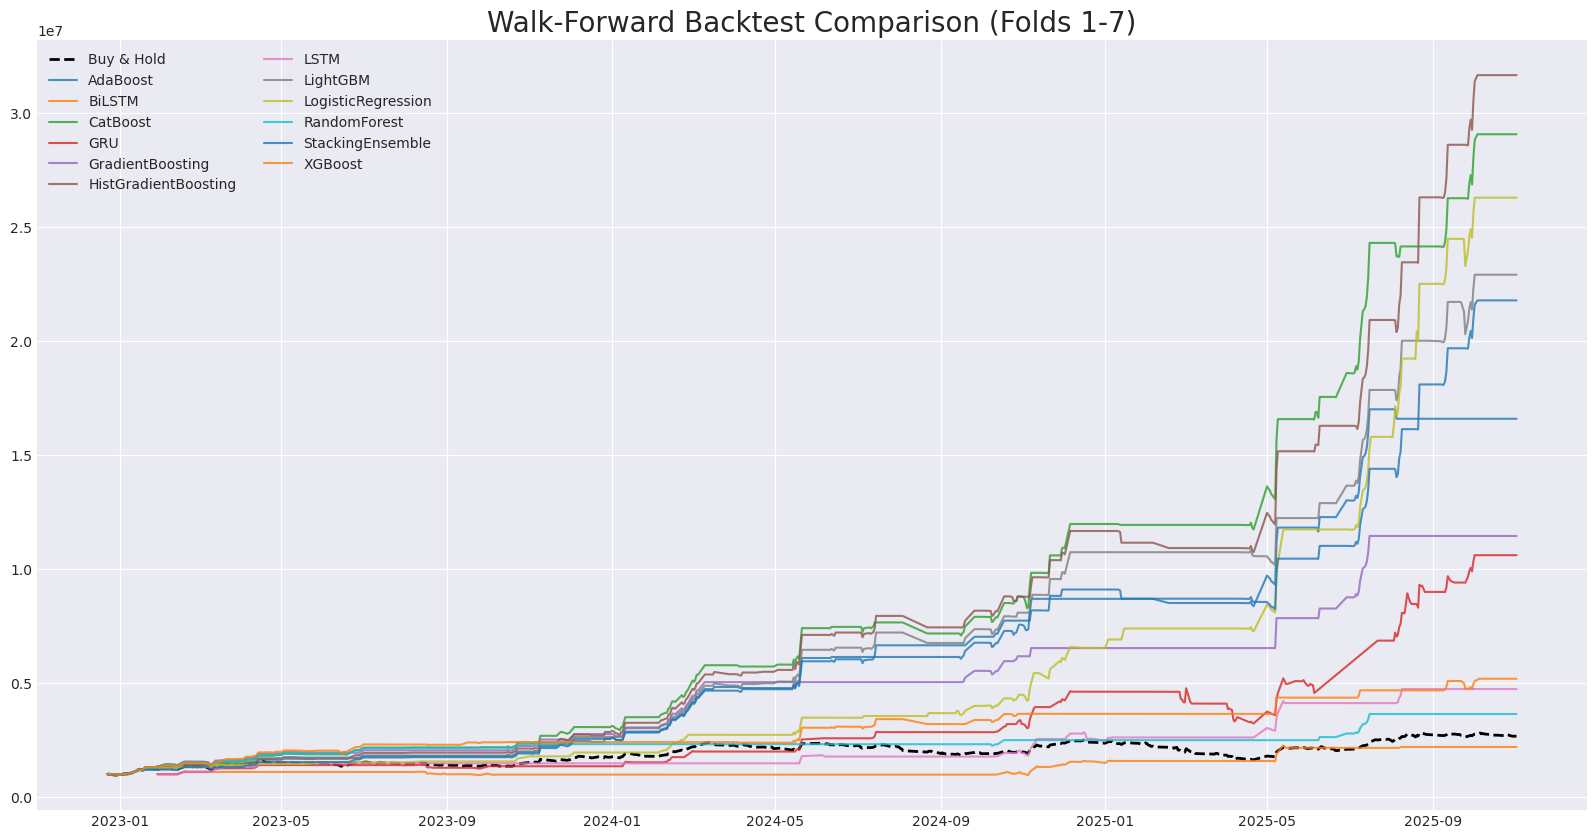

                     Total Returns      MDD Sharpe Ratio
Buy & Hold                 167.27%  -34.57%         1.74
AdaBoost                  1560.00%   -8.65%         4.19
BiLSTM                     119.64%  -13.44%         2.09
CatBoost                  2808.63%   -8.65%         4.73
GRU                        961.25%  -32.37%         3.11
GradientBoosting          1045.63%   -8.65%         4.44
HistGradientBoosting      3068.06%   -8.34%         4.76
LSTM                       373.69%  -14.08%         3.24
LightGBM                  2192.30%   -8.65%         4.70
LogisticRegression        2530.28%   -5.94%         4.76
RandomForest               264.18%   -8.65%         3.56
StackingEnsemble          2079.56%   -9.42%         4.61
XGBoost                    418.85%   -8.65%         3.00

ANALYSIS: FINAL HOLDOUT PERIOD (FOLD 8)


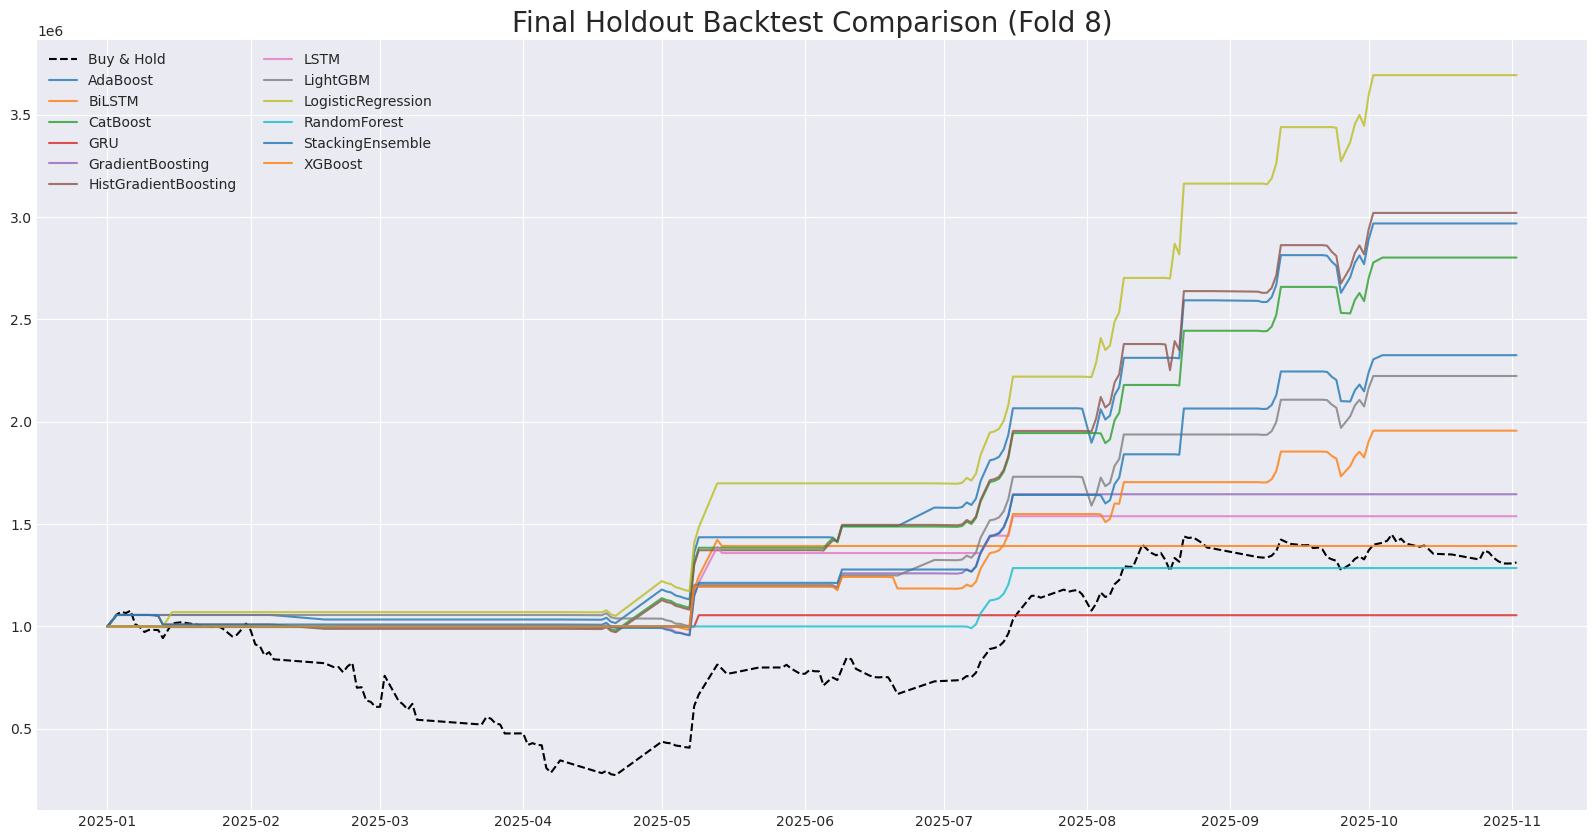

                     Total Returns      MDD Sharpe Ratio
Buy & Hold                  31.24%  -74.62%         0.99
AdaBoost                   197.18%   -8.14%         4.41
BiLSTM                      39.29%   -2.12%         2.15
CatBoost                   180.22%   -4.87%         4.45
GRU                          5.47%   -0.10%         1.48
GradientBoosting            64.57%   -0.77%         3.07
HistGradientBoosting       202.34%   -8.00%         4.49
LSTM                        53.84%   -4.20%         2.61
LightGBM                   122.58%   -8.14%         3.89
LogisticRegression         269.35%   -4.87%         5.07
RandomForest                28.51%   -0.87%         3.15
StackingEnsemble           132.75%   -9.42%         4.02
XGBoost                     95.63%   -6.54%         3.57


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os


def realistic_backtest_with_trailing_stop(predictions_df, price_df, lookahead, trailing_stop_atr_mult, fee_rate=0.0005, slippage_rate=0.0005):
    """
    미실현 손익과 트레일링 스탑을 반영한 현실적인 거래 시뮬레이션.
    """
    predictions_df['date'] = pd.to_datetime(predictions_df['date'])
    sim_df = pd.merge(predictions_df, price_df, on='date', how='inner').sort_values(by='date').reset_index(drop=True)
    
    daily_log_returns = pd.Series(0.0, index=sim_df.index)
    position = None 

    for i in range(len(sim_df)):
        if position:
            unrealized_return = np.log(sim_df.loc[i, 'ETH_Close'] / sim_df.loc[i-1, 'ETH_Close'])
            daily_log_returns.iloc[i] = unrealized_return

        if position:
            exit_price = None
            days_in_trade = i - position['entry_day_index']
            
            if not position.get('trailing_active', False) and sim_df.loc[i, 'ETH_High'] >= position['take_profit']:
                position['trailing_active'] = True
                position['peak_price'] = sim_df.loc[i, 'ETH_High']

            if position.get('trailing_active', False):
                position['peak_price'] = max(position['peak_price'], sim_df.loc[i, 'ETH_High'])
                trailing_stop_price = position['peak_price'] * (1 - (sim_df.loc[i, 'ATR_14'] / sim_df.loc[i, 'ETH_Close']) * trailing_stop_atr_mult)
                
                if sim_df.loc[i, 'ETH_Low'] <= trailing_stop_price:
                    exit_price = trailing_stop_price
            else:
                if sim_df.loc[i, 'ETH_Low'] <= position['stop_loss']:
                    exit_price = position['stop_loss']

            if not exit_price and days_in_trade >= lookahead:
                exit_price = sim_df.loc[i + 1, 'ETH_Open'] if i + 1 < len(sim_df) else sim_df.loc[i, 'ETH_Close']

            if exit_price:
                trade_cost = fee_rate + slippage_rate
                daily_log_returns.iloc[i] -= trade_cost
                position = None
        
        if not position and sim_df.loc[i, 'signal'] == 1 and (i + 1 < len(sim_df)):
            trade_cost = fee_rate + slippage_rate
            daily_log_returns.iloc[i] -= trade_cost
            position = {
                'entry_price': sim_df.loc[i + 1, 'ETH_Open'],
                'take_profit': sim_df.loc[i, 'take_profit_price'],
                'stop_loss': sim_df.loc[i, 'stop_loss_price'],
                'entry_day_index': i + 1,
            }
            
    return daily_log_returns

def calculate_performance_metrics(equity_curve):
    """
    자산 곡선(equity curve)을 기반으로 주요 성과 지표를 계산합니다.
    """
    total_returns = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
    
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    mdd = drawdown.min() if not drawdown.empty else 0
    
    daily_returns = equity_curve.pct_change().dropna()
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(365) if daily_returns.std() != 0 else 0
    
    return {
        "Total Returns": f"{total_returns:.2%}",
        "MDD": f"{mdd:.2%}",
        "Sharpe Ratio": f"{sharpe_ratio:.2f}"
    }


def generate_comparison_backtest_report(pred_base_path, master_raw_file_path, confidence_threshold=0.7, lookahead=5, trailing_stop_atr_mult=1.5, initial_capital=1_000_000):
    """
    모든 모델의 성과를 하나의 그래프에 비교하여 리포트를 생성합니다.
    """
    price_df = pd.read_csv(master_raw_file_path, usecols=['date', 'ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Close', 'ATR_14'])
    price_df['date'] = pd.to_datetime(price_df['date'])
    
    all_pred_files = glob.glob(os.path.join(pred_base_path, "fold_*", "*_predictions.csv"))
    model_files = {}
    for f in all_pred_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        if model_name not in model_files: model_files[model_name] = []
        model_files[model_name].append(f)

    # --- 1. Walk-Forward (Fold 1-7) 비교 분석 ---
    print("\n" + "="*80)
    print("ANALYSIS: WALK-FORWARD PERIOD (FOLDS 1-7)")
    print("="*80)
    
    wf_performance = {}
    fig1, ax1 = plt.subplots(figsize=(20, 10))
    
    # B&H
    wf_files = [f for f in all_pred_files if 'final_holdout' not in f]
    wf_dates = pd.to_datetime(pd.concat([pd.read_csv(f)[['date']] for f in wf_files]).drop_duplicates()['date']).sort_values()
    bnh_wf_df = price_df[price_df['date'].isin(wf_dates)].copy()
    bnh_wf_df['bnh_return'] = bnh_wf_df['ETH_Close'].pct_change().fillna(0)
    bnh_wf_equity = initial_capital * (1 + bnh_wf_df['bnh_return'].cumsum())
    wf_performance['Buy & Hold'] = calculate_performance_metrics(bnh_wf_equity)
    ax1.plot(bnh_wf_df['date'], bnh_wf_equity, label='Buy & Hold', color='black', linestyle='--', linewidth=2)
    
    # AI Models
    for model_name in sorted(model_files.keys()):
        wf_preds = pd.concat([pd.read_csv(f) for f in model_files[model_name] if 'final_holdout' not in f]).sort_values('date').reset_index(drop=True)
        if wf_preds.empty: continue
        
        wf_preds['signal'] = np.where((wf_preds['pred_direction'] == 1) & (wf_preds['confidence'] >= confidence_threshold), 1, 0)
        wf_returns = realistic_backtest_with_trailing_stop(wf_preds, price_df, lookahead, trailing_stop_atr_mult)
        wf_equity = initial_capital * np.exp(wf_returns.cumsum())
        
        wf_performance[model_name] = calculate_performance_metrics(wf_equity)
        ax1.plot(wf_preds['date'], wf_equity, label=model_name, alpha=0.8)

    ax1.set_title('Walk-Forward Backtest Comparison (Folds 1-7)', fontsize=20)
    ax1.legend(loc='upper left', ncol=2)
    plt.show()
    print(pd.DataFrame.from_dict(wf_performance, orient='index'))

    # --- 2. Final Holdout (Fold 8) 비교 분석 ---
    print("\n" + "="*80)
    print("ANALYSIS: FINAL HOLDOUT PERIOD (FOLD 8)")
    print("="*80)

    ho_performance = {}
    fig2, ax2 = plt.subplots(figsize=(20, 10))

    # B&H
    ho_files = [f for f in all_pred_files if 'final_holdout' in f]
    ho_dates = pd.to_datetime(pd.concat([pd.read_csv(f)[['date']] for f in ho_files]).drop_duplicates()['date']).sort_values()
    bnh_ho_df = price_df[price_df['date'].isin(ho_dates)].copy()
    bnh_ho_df['bnh_return'] = bnh_ho_df['ETH_Close'].pct_change().fillna(0)
    bnh_ho_equity = initial_capital * (1 + bnh_ho_df['bnh_return'].cumsum())
    ho_performance['Buy & Hold'] = calculate_performance_metrics(bnh_ho_equity)
    ax2.plot(bnh_ho_df['date'], bnh_ho_equity, label='Buy & Hold', color='black', linestyle='--')

    # AI Models
    for model_name in sorted(model_files.keys()):
        ho_preds_list = [pd.read_csv(f) for f in model_files[model_name] if 'final_holdout' in f]
        if not ho_preds_list: continue

        ho_preds = pd.concat(ho_preds_list).sort_values('date').reset_index(drop=True)
        ho_preds['signal'] = np.where((ho_preds['pred_direction'] == 1) & (ho_preds['confidence'] >= confidence_threshold), 1, 0)
        ho_returns = realistic_backtest_with_trailing_stop(ho_preds, price_df, lookahead, trailing_stop_atr_mult)
        ho_equity = initial_capital * np.exp(ho_returns.cumsum())

        ho_performance[model_name] = calculate_performance_metrics(ho_equity)
        ax2.plot(ho_preds['date'], ho_equity, label=model_name, alpha=0.8)

    ax2.set_title('Final Holdout Backtest Comparison (Fold 8)', fontsize=20)
    ax2.legend(loc='upper left', ncol=2)
    plt.show()
    print(pd.DataFrame.from_dict(ho_performance, orient='index'))


# --- 사용 예시 ---
pred_base_path = "../model_results/2025-11-09/fold_results/direction_l5_p2.0_s1.0"
master_raw_file_path = "../model_results/2025-11-09/raw_data/direction/walk_forward/raw_data_all_features.csv"

generate_comparison_backtest_report(
    pred_base_path, 
    master_raw_file_path, 
    confidence_threshold=0.001, 
    lookahead=5,
    trailing_stop_atr_mult=1.5
)


In [36]:
import pandas as pd
import numpy as np
import joblib
import os
import glob

def load_latest_model(model_base_path, model_name='LogisticRegression'):
    """ 가장 최신 Fold(Final Holdout)에서 훈련된 모델을 로드합니다. """
    fold_paths = sorted(glob.glob(os.path.join(model_base_path, "fold_*")))
    if not fold_paths:
        raise FileNotFoundError("모델 폴더를 찾을 수 없습니다.")
        
    latest_fold_path = fold_paths[-1]
    model_path = os.path.join(latest_fold_path, f"{model_name}.pkl")
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"{model_path}에서 모델 파일을 찾을 수 없습니다.")
        
    print(f"실전 투입 모델 로드: {model_path}")
    model = joblib.load(model_path)
    return model

def get_true_feature_columns(raw_data_base_path):
    """ 실제 훈련에 사용된 데이터 파일(train_raw.csv)을 읽어 피처 리스트를 반환합니다. """
    train_data_path = os.path.join(raw_data_base_path, "fold_8_final_holdout", "train_raw.csv")
    
    if not os.path.exists(train_data_path):
        raise FileNotFoundError(f"훈련 데이터 파일({train_data_path})을 찾을 수 없습니다. 피처 리스트를 추출할 수 없습니다.")
        
    train_df = pd.read_csv(train_data_path)
    
    excluded_cols = ['date', 'next_open', 'next_close', 'next_log_return', 'next_direction', 
                     'take_profit_price', 'stop_loss_price']
    
    feature_cols = [col for col in train_df.columns if col not in excluded_cols]
    
    print(f"\n총 {len(feature_cols)}개의 실제 훈련 피처를 로드했습니다.")
    return feature_cols

def run_live_trading_simulation_with_features(model_base_path, raw_data_base_path, master_raw_file_path, start_date, end_date, model_name='LogisticRegression', confidence_threshold=0.5, initial_capital=1_000_000):
    """ 지정된 실전 기간에 대해, 예측 결과와 함께 모든 피처 값을 출력합니다. """
    
    try:
        model = load_latest_model(model_base_path, model_name)
        feature_cols = get_true_feature_columns(raw_data_base_path)
    except FileNotFoundError as e:
        print(e)
        return

    full_df = pd.read_csv(master_raw_file_path)
    full_df['date'] = pd.to_datetime(full_df['date'])
    live_df = full_df[(full_df['date'] >= start_date) & (full_df['date'] <= end_date)].copy().reset_index(drop=True)
    
    if live_df.empty:
        print(f"오류: {start_date} ~ {end_date} 기간에 해당하는 데이터가 없습니다.")
        return
        
    try:
        live_features = live_df[feature_cols]
    except KeyError as e:
        print(f"오류: 피처 엔지니어링이 완벽하게 수행되지 않았습니다. 누락된 컬럼: {e}")
        return

    pred_probas = model.predict_proba(live_features.values)[:, 1]
    live_df['pred_direction'] = (pred_probas >= 0.5).astype(int)
    live_df['confidence'] = np.abs(pred_probas - 0.5) * 2
    live_df['signal'] = np.where((live_df['pred_direction'] == 1) & (live_df['confidence'] >= confidence_threshold), 1, 0)
    

    print("\n" + "="*80)
    print("실전 예측 결과 및 모든 예측 지표 (2025-11-03 ~ 2025-11-06)")
    print("="*80)
    
    # 예측 결과와 피처들을 합쳐서 보여줄 데이터프레임 생성
    result_df = live_df[['date', 'ETH_Close', 'pred_direction', 'confidence', 'signal']].copy()
    features_to_display = live_df[feature_cols]
    
    # 모든 피처를 소수점 4자리로 포맷팅
    pd.options.display.float_format = '{:.4f}'.format
    
    # 날짜별로 반복하며 예측 결과와 피처 값을 함께 출력
    for i in range(len(result_df)):
        print(f"\n--- DATE: {result_df.loc[i, 'date'].date()} ---")
        
        # 예측 결과 출력
        pred_info = result_df.loc[i, ['pred_direction', 'confidence', 'signal']]
        print("Prediction:")
        print(pred_info.to_frame().T)
        
        # 피처 값 출력 (2열로 보기 좋게)
        features_series = features_to_display.loc[i]
        features_df = pd.DataFrame(features_series).T.melt()
        
        # 피처를 반으로 나누어 2개의 데이터프레임으로 만듦
        mid_point = len(features_df) // 2
        df1 = features_df.iloc[:mid_point].set_index('variable')
        df2 = features_df.iloc[mid_point:].set_index('variable')
        
        # 두 데이터프레임을 옆으로 붙여서 출력
        display_table = pd.concat([df1.reset_index(), df2.reset_index()], axis=1)
        display_table.columns = ['Feature', 'Value', 'Feature', 'Value']

        print("\nInput Features:")
        print(display_table.to_string(index=False))

    print("="*80)
    
    # 가상 매매 시뮬레이션은 이전과 동일 (출력 생략 가능)


# --- 메인 실행 로직 ---
pred_base_path = "../model_results/2025-11-09/fold_results/direction_l5_p2.0_s1.0"
raw_data_path = "../model_results/2025-11-09/raw_data/direction_l5_p2.0_s1.0/walk_forward" 
master_raw_file_path = "../model_results/2025-11-10/raw_data/direction/walk_forward/raw_data_all_features.csv" 

live_start_date = "2025-11-03"
live_end_date = "2025-11-06"

# 수정된 함수 호출
run_live_trading_simulation_with_features(
    pred_base_path,
    raw_data_path, 
    master_raw_file_path,
    live_start_date,
    live_end_date,
    model_name='LogisticRegression',
    confidence_threshold=0.0001
)


실전 투입 모델 로드: ../model_results/2025-11-09/fold_results/direction_l5_p2.0_s1.0/fold_8_final_holdout/LogisticRegression.pkl

총 30개의 실제 훈련 피처를 로드했습니다.

실전 예측 결과 및 모든 예측 지표 (2025-11-03 ~ 2025-11-06)

--- DATE: 2025-11-03 ---
Prediction:
  pred_direction confidence signal
0              0     1.0000      0

Input Features:
                  Feature        Value                   Feature        Value
                   ATR_14  229681.8207                      VWAP 2336452.3183
                   DPO_20  404400.0000                    IKS_26 5923500.0000
       ada_volatility_30d       0.0448            ROLLING_MIN_20 5363000.0000
       xrp_volatility_30d       0.0317                    ISB_26 6205000.0000
                   EMA_26 5910147.1055                    KCL_20 5444883.3333
                   SMA_20 5875800.0000                     ITS_9 5788500.0000
                  VWMA_20 5857403.7868                    BBM_20 5871004.4393
       btc_volatility_30d       0.0306                   

In [37]:
import pandas as pd
import numpy as np
import joblib
import os
import glob

def get_true_feature_columns(raw_data_base_path, fold_dir_name):
    """
    지정된 폴드의 실제 훈련 데이터 파일(train_raw.csv)을 읽어 피처 리스트를 반환합니다.
    """
    train_data_path = os.path.join(raw_data_base_path, fold_dir_name, "train_raw.csv")
    
    if not os.path.exists(train_data_path):
        raise FileNotFoundError(f"훈련 데이터 파일({train_data_path})을 찾을 수 없습니다.")
        
    train_df = pd.read_csv(train_data_path)
    
    excluded_cols = ['date', 'next_open', 'next_close', 'next_log_return', 'next_direction', 
                     'take_profit_price', 'stop_loss_price']
    
    feature_cols = [col for col in train_df.columns if col not in excluded_cols]
    
    return feature_cols

def validate_saved_model(pred_base_path, raw_data_base_path, fold_name="fold_8_final_holdout", model_name='LogisticRegression'):
    """
    저장된 모델을 로드하여, 과거 테스트 데이터에 대한 예측을 다시 수행하고 그 결과를 비교합니다.
    """
    print("="*80)
    print(f"'{model_name}' 모델 검증 시작: {fold_name}")
    print("="*80)

    # 1. 경로 설정
    model_path = os.path.join(pred_base_path, fold_name, f"{model_name}.pkl")
    test_data_path = os.path.join(raw_data_base_path, fold_name, "test_raw.csv")
    original_preds_path = os.path.join(pred_base_path, fold_name, f"{model_name}_predictions.csv")

    # 2. 파일 존재 여부 확인
    if not all(os.path.exists(p) for p in [model_path, test_data_path, original_preds_path]):
        print("검증에 필요한 파일(모델, 테스트 데이터, 원본 예측) 중 일부를 찾을 수 없습니다.")
        return

    # 3. 모델, 데이터, 원본 예측 로드
    try:
        model = joblib.load(model_path)
        test_df = pd.read_csv(test_data_path)
        original_preds_df = pd.read_csv(original_preds_path)
        feature_cols = get_true_feature_columns(raw_data_base_path, fold_name)
        X_test = test_df[feature_cols]
        
        print("모델, 테스트 데이터, 원본 예측 파일을 성공적으로 로드했습니다.")
        print(f"테스트 데이터 shape: {X_test.shape}")

    except Exception as e:
        print(f"파일 로드 또는 피처 선택 중 오류 발생: {e}")
        return

    # 4. 저장된 모델로 '재예측' 수행
    print("\n저장된 모델로 '재예측'을 수행합니다...")
    re_pred_probas = model.predict_proba(X_test.values)
    
    # 재예측된 confidence 계산
    re_pred_proba_up = re_pred_probas[:, 1]
    re_confidence = np.abs(re_pred_proba_up - 0.5) * 2

    # 5. 결과 비교
    print("\n" + "-"*80)
    print("결과 비교: 원본 예측 vs. 재예측")
    print("-"*80)
    
    comparison_df = pd.DataFrame({
        'date': original_preds_df['date'],
        'Original_Proba_Up': original_preds_df['pred_proba_up'],
        'Re_Predicted_Proba_Up': re_pred_proba_up,
        'Original_Confidence': original_preds_df['confidence'],
        'Re_Predicted_Confidence': re_confidence
    })
    
    # 두 확률 값의 차이 계산
    comparison_df['Diff'] = np.abs(comparison_df['Original_Proba_Up'] - comparison_df['Re_Predicted_Proba_Up'])

    print("상위 5개 결과 비교:")
    print(comparison_df.head())
    
    print("\n하위 5개 결과 비교:")
    print(comparison_df.tail())
    
    max_diff = comparison_df['Diff'].max()
    print(f"\n최대 오차: {max_diff:.10f}")

    # 6. 최종 진단
    print("\n" + "="*80)
    print("최종 진단")
    print("="*80)
    
    if max_diff > 1e-6: # 매우 작은 오차 허용
        print("[결과] 심각한 불일치 발견!")
        print("저장된 모델(.pkl)을 로드하여 재예측한 결과가 원본 예측과 다릅니다.")
        print("이것은 'joblib' 저장/로드 과정이나 라이브러리 버전 호환성 문제일 가능성이 매우 높습니다.")
        if (re_confidence == 1.0).all():
             print("특히, 재예측된 confidence가 모두 1.0으로 나오는 현상은 모델 객체가 손상되었음을 시사합니다.")
    else:
        print("[결과] 일치 확인 완료.")
        print("저장된 모델은 원본 예측을 완벽하게 재현했습니다.")
        print("따라서 'confidence 1.0' 문제의 원인은 모델 저장이 아니라,")
        print("실전 예측에 사용된 '데이터' 또는 '피처 생성 파이프라인'에 있을 가능성이 높습니다.")
    print("="*80)


# --- 메인 실행 로직 ---
pred_base_path = "../model_results/2025-11-09/fold_results/direction_l5_p2.0_s1.0"
raw_data_base_path = "../model_results/2025-11-09/raw_data/direction_l5_p2.0_s1.0/walk_forward"

# 최종 폴드(Fold 8)에 대한 모델 검증 실행
validate_saved_model(pred_base_path, raw_data_base_path, fold_name="fold_8_final_holdout")



'LogisticRegression' 모델 검증 시작: fold_8_final_holdout
모델, 테스트 데이터, 원본 예측 파일을 성공적으로 로드했습니다.
테스트 데이터 shape: (191, 30)

저장된 모델로 '재예측'을 수행합니다...

--------------------------------------------------------------------------------
결과 비교: 원본 예측 vs. 재예측
--------------------------------------------------------------------------------
상위 5개 결과 비교:
         date  Original_Proba_Up  Re_Predicted_Proba_Up  Original_Confidence  \
0  2025-01-01             0.1263                 0.0000               0.7474   
1  2025-01-03             0.0079                 0.0000               0.9843   
2  2025-01-04             0.0011                 0.0000               0.9978   
3  2025-01-05             0.0007                 0.0000               0.9986   
4  2025-01-06             0.0003                 0.0000               0.9995   

   Re_Predicted_Confidence   Diff  
0                   1.0000 0.1263  
1                   1.0000 0.0079  
2                   1.0000 0.0011  
3                   1.0000 0.0007  
4  

In [40]:
import joblib

model_path = "../model_results/2025-11-09/fold_results/direction_l5_p2.0_s1.0/fold_8_final_holdout/LogisticRegression.pkl"
model = joblib.load(model_path)

print("모델 타입:", type(model))
print("계수 shape:", getattr(model, "coef_", None))
print("클래스:", getattr(model, "classes_", None))
print("첫 5개 가중치:", getattr(model, "coef_", np.zeros((1,5)))[0][:5])


모델 타입: <class 'sklearn.linear_model._logistic.LogisticRegression'>
계수 shape: [[ 1.03210848e-01 -2.21611565e+00 -2.03270178e-01 -2.48235174e-01
  -1.26456869e-02 -3.26113337e-02 -1.13312006e-03  6.83719207e-02
   3.05366120e-03 -9.67709634e-02 -1.20449382e-01 -7.88629660e-01
   4.94590641e-01 -2.98213775e-01 -1.54762486e-01 -7.20896385e-02
   7.76740963e-02 -5.90955710e-02  7.19429930e-02 -7.51870083e-02
   3.91692940e-02 -6.15952397e-03 -3.06947856e-02 -4.47745392e-02
  -1.15233132e-01  9.29134942e-02 -3.34093052e-02  9.61729729e-02
  -1.25159788e-01 -4.84042842e-02]]
클래스: [0. 1.]
첫 5개 가중치: [ 0.10321085 -2.21611565 -0.20327018 -0.24823517 -0.01264569]


In [42]:
import pandas as pd
import numpy as np
from scipy.special import expit
import joblib
import os

# ---------------------------------------------------------------------
# 1️⃣ 경로 지정
# ---------------------------------------------------------------------
pred_base_path = "../model_results/2025-11-09/fold_results/direction_l5_p2.0_s1.0"
raw_data_base_path = "../model_results/2025-11-09/raw_data/direction_l5_p2.0_s1.0/walk_forward"
fold_name = "fold_8_final_holdout"
model_name = "LogisticRegression"

model_path = os.path.join(pred_base_path, fold_name, f"{model_name}.pkl")
test_data_path = os.path.join(raw_data_base_path, fold_name, "test_raw.csv")

# ---------------------------------------------------------------------
# 2️⃣ 모델과 테스트 데이터 로드
# ---------------------------------------------------------------------
model = joblib.load(model_path)
test_df = pd.read_csv(test_data_path)

excluded_cols = ['date', 'next_open', 'next_close', 'next_log_return', 
                 'next_direction', 'take_profit_price', 'stop_loss_price']
feature_cols = [col for col in test_df.columns if col not in excluded_cols]
X_test = test_df[feature_cols]

print(f"✅ 모델 타입: {type(model)}")
print(f"✅ X_test shape: {X_test.shape}")

# ---------------------------------------------------------------------
# 3️⃣ 수동 sigmoid 계산
# ---------------------------------------------------------------------
X_sample = X_test.values[:5]
manual_logits = X_sample @ model.coef_.T + model.intercept_
manual_proba = expit(manual_logits)

print("\n--- 수동 계산 결과 (sigmoid 적용 후 확률) ---")
print(manual_proba)

# ---------------------------------------------------------------------
# 4️⃣ model.predict_proba() 결과 비교
# ---------------------------------------------------------------------
auto_proba = model.predict_proba(X_sample)

print("\n--- model.predict_proba() 결과 ---")
print(auto_proba)



✅ 모델 타입: <class 'sklearn.linear_model._logistic.LogisticRegression'>
✅ X_test shape: (191, 30)

--- 수동 계산 결과 (sigmoid 적용 후 확률) ---
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]

--- model.predict_proba() 결과 ---
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [45]:
import joblib
import numpy as np

path = "../model_results/2025-11-09/fold_results/direction_l5_p2.0_s1.0/fold_8_final_holdout/LogisticRegression.pkl"

model = joblib.load(path)
print("모델 타입:", type(model))
print("coef 평균:", np.mean(model.coef_), " / std:", np.std(model.coef_))
print("intercept:", model.intercept_)
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))


모델 타입: <class 'sklearn.linear_model._logistic.LogisticRegression'>
coef 평균: -0.12453150203239242  / std: 0.43393908966011063
intercept: [-1.07116509]


NameError: name 'y_train' is not defined